In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#pip install tensorflow

In [3]:
#pip install optree

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
train_dir = r'C:\Users\Bharath\OneDrive\Documents\Docs\DS\MRI\Training'
test_dir = r'C:\Users\Bharath\OneDrive\Documents\Docs\DS\MRI\Testing'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split a portion of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Use the training subset
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='validation'  # Use the validation subset
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 classes for multi-class classification

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20


C:\Users\Bharath\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.5222 - loss: 1.3850 - val_accuracy: 0.6564 - val_loss: 0.8388
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 655s 5s/step - accuracy: 0.6825 - loss: 0.7251 - val_accuracy: 0.7160 - val_loss: 0.7538
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 656s 5s/step - accuracy: 0.7125 - loss: 0.6835 - val_accuracy: 0.7406 - val_loss: 0.7038
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 651s 5s/step - accuracy: 0.7302 - loss: 0.6029 - val_accuracy: 0.7283 - val_loss: 0.6821
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.7546 - loss: 0.5769 - val_accuracy: 0.7134 - val_loss: 0.7360
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 799s 6s/step - accuracy: 0.7681 - loss: 0.5651 - val_accuracy: 0.7616 - val_loss: 0.6584
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 786s 5s/step - accuracy: 0.7673 - loss: 0.5578 - val_accuracy: 0.7423 - val_loss: 0.6822
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 685s 5s/step - accuracy: 0.7818 - loss: 0.5566 - val_accuracy: 0.714

41/41 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.6961 - loss: 0.7991
Test Accuracy: 80.93%
41/41 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step


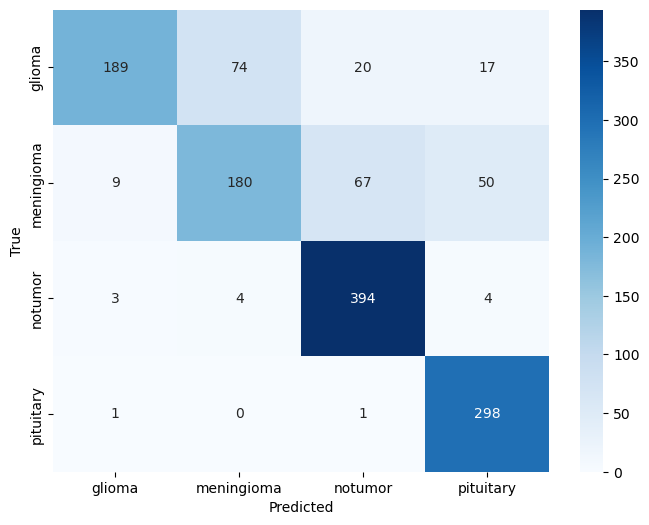

              precision    recall  f1-score   support

      glioma       0.94      0.63      0.75       300
  meningioma       0.70      0.59      0.64       306
     notumor       0.82      0.97      0.89       405
   pituitary       0.81      0.99      0.89       300

    accuracy                           0.81      1311
   macro avg       0.81      0.80      0.79      1311
weighted avg       0.81      0.81      0.80      1311



In [10]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


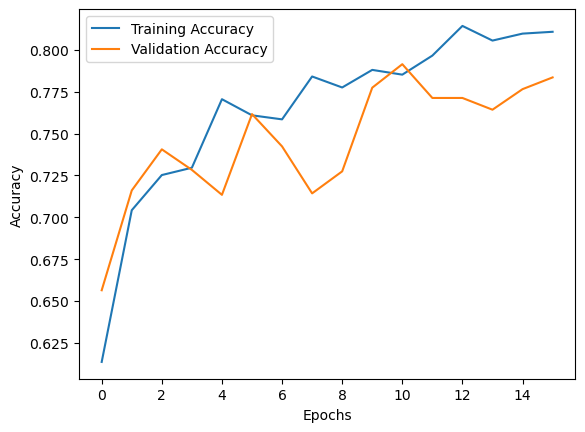

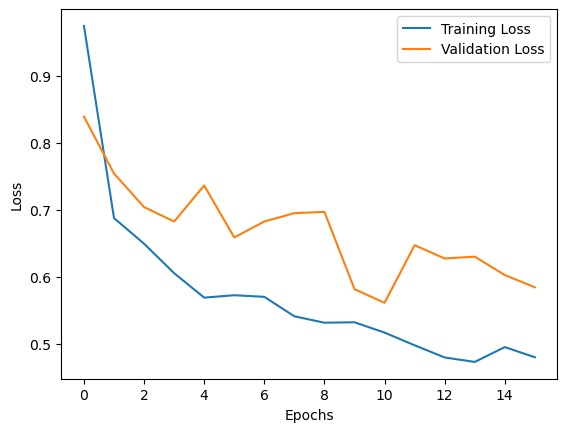

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
#!pip install tensorflow

In [14]:
# Classification report (includes precision, recall, and F1-score)
#print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


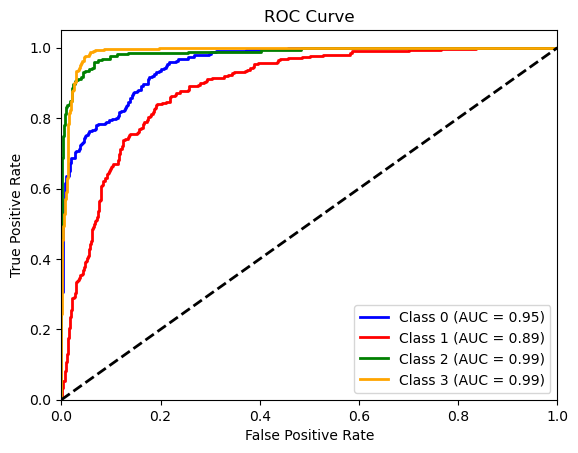

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC curve
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])  # Adjust based on the number of classes

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # Adjust based on the number of classes
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(4), colors):  # Adjust based on the number of classes
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


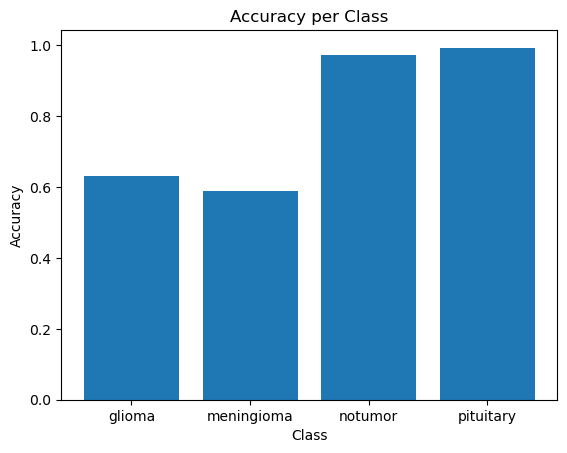

In [17]:
# Accuracy per class
class_totals = np.sum(cm, axis=1)
class_corrects = np.diag(cm)
class_accuracies = class_corrects / class_totals

# Plot accuracy per class
plt.bar(test_generator.class_indices.keys(), class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.show()


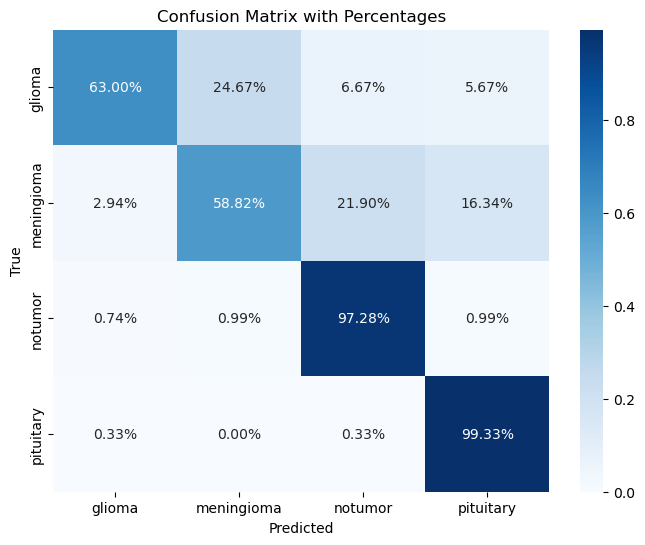

In [18]:
# Confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Percentages')
plt.show()


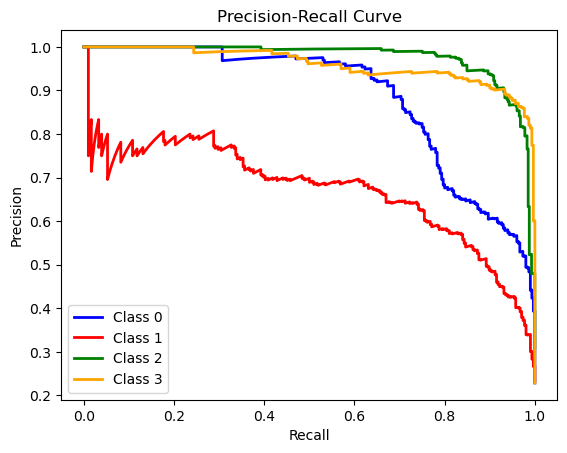

In [19]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for each class
precision = {}
recall = {}

for i in range(4):  # Adjust based on the number of classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])

# Plot precision-recall curve for each class
plt.figure()
for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {i}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


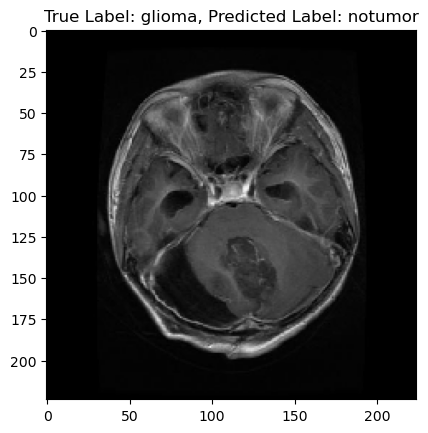

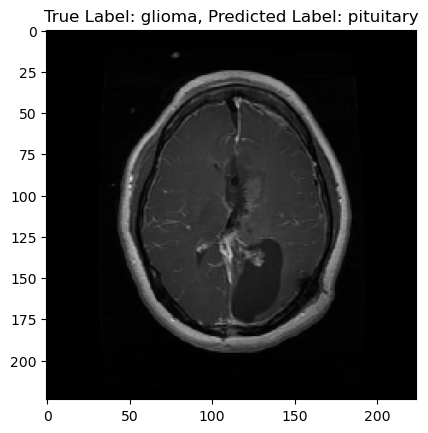

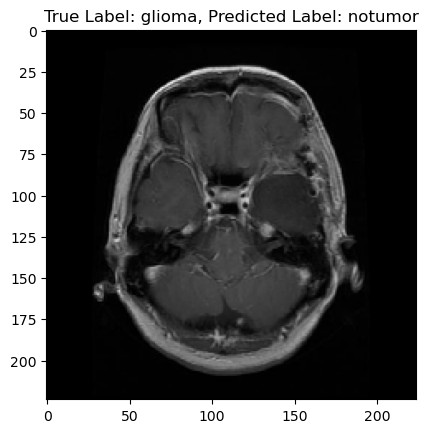

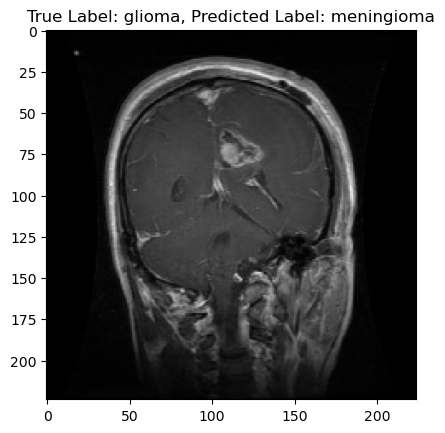

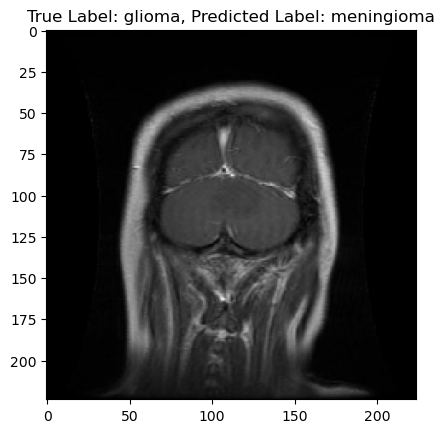

In [21]:
# Get misclassified indices
misclassified_idx = np.where(y_true != y_pred_classes)[0]

# Display the top 5 misclassified images
for i in range(5):
    img, label = test_generator[misclassified_idx[i]]
    plt.imshow(img[0])
    plt.title(f'True Label: {list(test_generator.class_indices.keys())[y_true[misclassified_idx[i]]]}, Predicted Label: {list(test_generator.class_indices.keys())[y_pred_classes[misclassified_idx[i]]]}')
    plt.show()
